In [1]:
#loading data!

In [29]:
import numpy as np
import sqlite3
import pandas as pd
import re
import tarfile as tf
import quantities as pq
import xml.etree.ElementTree as et
import pdb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from scipy import stats

In [2]:
def regexp(expr, item):
    reg = re.compile(expr)
    return reg.search(item) is not None

In [3]:
class ReadSession:
    def __init__(self,
                 dataset,
                 path,
                 animal_id,
                 day,
                 beh,
                 session,
                 unit_spiketime,
                 unit_space,
                 unit_lfp=pq.V,
                 load_lfp=False):

        meta_path = path + dataset + '/docs/' + dataset.replace('-', '') +\
                    '-metadata-tables/' + dataset.replace('-', '') +\
                    '-tables.db'

        # Open database
        con_sessions = sqlite3.connect(meta_path)
        con_sessions.create_function("REGEXP", 2, regexp)

        topdir = animal_id 
        subdir = str(session)
        
        df_session = pd.read_sql_query(
            'SELECT ' +
            'topdir, ' +
            'session, ' +
            'behavior, ' +
            'familiarity, ' +
            'duration ' +
            'from session where behavior=\'' +
            beh +
            '\' AND session=\'' +
            subdir +
            '\' AND topdir=\'' +
            topdir +
            '\'', con_sessions)

        df_cells = pd.read_sql_query(
            'SELECT ' +
            'id, ' +
            'topdir, ' +
            'animal, ' +
            'ele, ' +
            'clu, ' +
            'region, ' +
            'nexciting, ' +
            'ninhibiting, ' +
            'exciting, ' +
            'inhibiting, ' +
            'excited, ' +
            'inhibited, ' +
            'fireRate, ' +
            'totalFireRate, ' +
            'cellType ' +
            'From cell where topdir REGEXP \'' +
            topdir + '\'',
            con_sessions)
        
        df_epos = pd.read_sql_query(
            'SELECT ' +
            'topdir, ' +
            'animal, ' +
            'e1, ' +
            'e2, ' +
            'e3, ' +
            'e4, ' +
            'e5, ' +
            'e6, ' +
            'e7, ' +
            'e8, ' +
            'e9, ' +
            'e10, ' +
            'e11, ' +
            'e12, ' +
            'e13, ' +
            'e14, ' +
            'e15, ' +
            'e16 ' +
            'From epos where topdir REGEXP \'' +
            topdir + '\'',
            con_sessions)
        
        electrode_ids = np.unique(df_cells['ele'])
        path_to_session = path + dataset + '/' + \
            topdir + '/' +\
            subdir + '.tar.gz'

        # extract variables from data
        clusters = {}
        times = {}
        with tf.open(path_to_session) as tf_session:
            # get sampling rate of spike timestamps

            xml_f = tf_session.extractfile(
                topdir + '/' +
                subdir + '/' +
                subdir + '.xml')
            e = et.parse(xml_f).getroot()
            sampling_rate_spike_time = float(
                e.findall("./acquisitionSystem/samplingRate")[0].text)

            # get animal position
            # positions_file = tf_session.extractfile(
            #     topdir + '/' +
            #     subdir + '/' +
            #     subdir + '.whl')
            # positions_file_lines =[np.array(line.split(), dtype=np.float64) for line in positions_file.readlines()]
    
            # positions = np.stack(positions_file_lines)
            
            
            for ele_i in electrode_ids:
                clusters_f = tf_session.extractfile(
                    topdir + '/' +
                    subdir + '/' +
                    subdir + '.clu.' + str(ele_i))
                # read cluster file
                clusters_i = np.array([int(clu_id) for clu_id in clusters_f ])
                # first line contains number of clusters in file, skip it
                
                
                clusters_i = clusters_i[1:]
                
                times_f = tf_session.extractfile(
                    topdir + '/' +
                    subdir + '/' +
                    subdir + '.res.' + str(ele_i))
                # get times of spikes
                times_i= np.array([float(time_j) for time_j in times_f])*unit_spiketime
                # divide by sampling rate
                times_i /= sampling_rate_spike_time
                
                # from documentation:
                # cluster 0 corresponds to mechanical noise (the wave shapes
                # do not look like neuron's spike). Cluster 1 corresponds to
                # small, unsortable spikes. These two clusters (0 and 1) should
                # not be used for analysis of neural data since they do not
                # correspond to successfully sorted spikes.

                # remove clusters == 0 and == 1
                pos_cluster_not_0_or_1 = np.where(clusters_i >= 2)[0]
                clusters_i = clusters_i[pos_cluster_not_0_or_1]
                times_i = times_i[pos_cluster_not_0_or_1]
                clusters[ele_i] = clusters_i
                times[ele_i] = times_i

                    
       # positions = positions * unit_space
        
        def data_spikes(electrode_ids,clusters,times):
            combined_arrays = []
            electrodeids = []
            for i in electrode_ids:
                combined_spike_time_i=np.column_stack((clusters[i],times[i]))
                combined_arrays.append(combined_spike_time_i)
                electrodeids_i = np.full((combined_spike_time_i.shape[0], 1), i)
                electrodeids.append(electrodeids_i)


            combined_array_all = np.vstack(
                [np.hstack((electrodeids[i], combined_arrays[i])) for i in range(len(electrode_ids))]
            )

            df = pd.DataFrame(data=combined_array_all, columns=['Electrode ID', 'Cluster', 'Time'])
            return df

        self.df_session = df_session
        self.df_cells = df_cells
        self.dataset = dataset
        self.path = path
        self.animal_id = animal_id
        self.day = day
        self.beh = beh
        self.session = session
        self.unit_spiketime = unit_spiketime
        self.unit_space = unit_space
        self.data_spikes= data_spikes(electrode_ids, clusters, times)
    


## Continue with an example! 

In [4]:
dataset = "hc-3"
path = "D:/37/"
animal_id = "gor01-6-7"
day = 2006-6-7
beh = "linearTwo"
session = "2006-6-7_16-40-19"
unit_spiketime = pq.ms
unit_space = pq.mm
load_lfp = False  # no need to set True!

data=ReadSession(dataset,path,animal_id,day,beh,session,unit_spiketime,unit_space,load_lfp)

spike_time=data.data_spikes #get spikes and their times
cell=data.df_cells #get type of neurons and regions 

merged_df =spike_time.merge(cell, left_on=['Electrode ID', 'Cluster'], right_on=['ele', 'clu'], how='left')
drop_list=['id', 'topdir', 'animal', 'ele','clu', 'fireRate','nexciting','ninhibiting',
           'exciting', 'inhibiting', 'excited', 'inhibited', 'totalFireRate']
spike_time_cell= merged_df.drop(columns=drop_list,axis=1) #mix all: type cell, spikes, regions, clusters and electrod ids
print(spike_time_cell.head)


<bound method NDFrame.head of         Electrode ID  Cluster         Time region cellType
0                1.0      3.0     1.081961    CA3        p
1                1.0      3.0     1.107705    CA3        p
2                1.0      3.0     1.301640    CA3        p
3                1.0      5.0     6.520122    CA3        p
4                1.0      3.0     7.962859    CA3        p
...              ...      ...          ...    ...      ...
840181          12.0      3.0  2584.389684    CA1        p
840182          12.0      4.0  2586.562669    CA1        p
840183          12.0      4.0  2586.618549    CA1        p
840184          12.0      4.0  2587.561225    CA1        p
840185          12.0      4.0  2587.565741    CA1        p

[840186 rows x 5 columns]>


# Correlation Matrixes  

In [5]:
bin_width = 25
start_time = 0  
end_time = 2588.00
time_bins = np.arange(start_time, end_time + bin_width, bin_width)

#counting the number of spikes for each pyramidal neuron per time window?!

def count_spikes_per_neurons(df, time_bins):
    neurons_counts = []
    for bin_start, bin_end in zip(time_bins[:-1], time_bins[1:]):
        bin_counts = df[(df['Time'] >= bin_start) & (df['Time'] < bin_end) & (df['cellType'] == 'p')].groupby(['region', 'Electrode ID','Cluster']).count()['Time']
        neurons_counts.append(bin_counts)
    return pd.concat(neurons_counts, axis=1, keys=time_bins[:-1])

spikes_counts_per_neurons = count_spikes_per_neurons(spike_time_cell, time_bins).fillna(0).transpose()
spikes_counts_per_neurons_sorted = spikes_counts_per_neurons.sort_index(axis=1, level=[0, 1, 2])
print(spikes_counts_per_neurons_sorted.head())


region        CA1                                                            \
Electrode ID 10.0  11.0                             12.0                      
Cluster      2.0   2.0    3.0   5.0    6.0    7.0   2.0    3.0   4.0   5.0    
0.0           3.0   7.0  171.0  21.0   94.0   89.0  13.0   67.0  44.0  75.0   
25.0          1.0  10.0  101.0   2.0   29.0  226.0  35.0   30.0  58.0   2.0   
50.0          0.0   1.0   60.0   3.0  142.0  185.0   3.0  147.0  19.0  99.0   
75.0          1.0   0.0   14.0   6.0   42.0  241.0  12.0  104.0   8.0  32.0   
100.0         0.0   0.0   14.0   5.0   47.0  235.0   4.0  162.0   7.0  28.0   

region        ...  CA3                                                     
Electrode ID  ... 8.0                                                      
Cluster       ... 7.0   8.0  9.0   10.0 11.0 12.0  13.0 14.0   15.0  17.0  
0.0           ...  6.0  13.0  6.0  17.0  3.0  8.0  85.0  4.0    3.0  59.0  
25.0          ...  0.0   0.0  2.0   2.0  4.0  0.0   1.0  2.0   

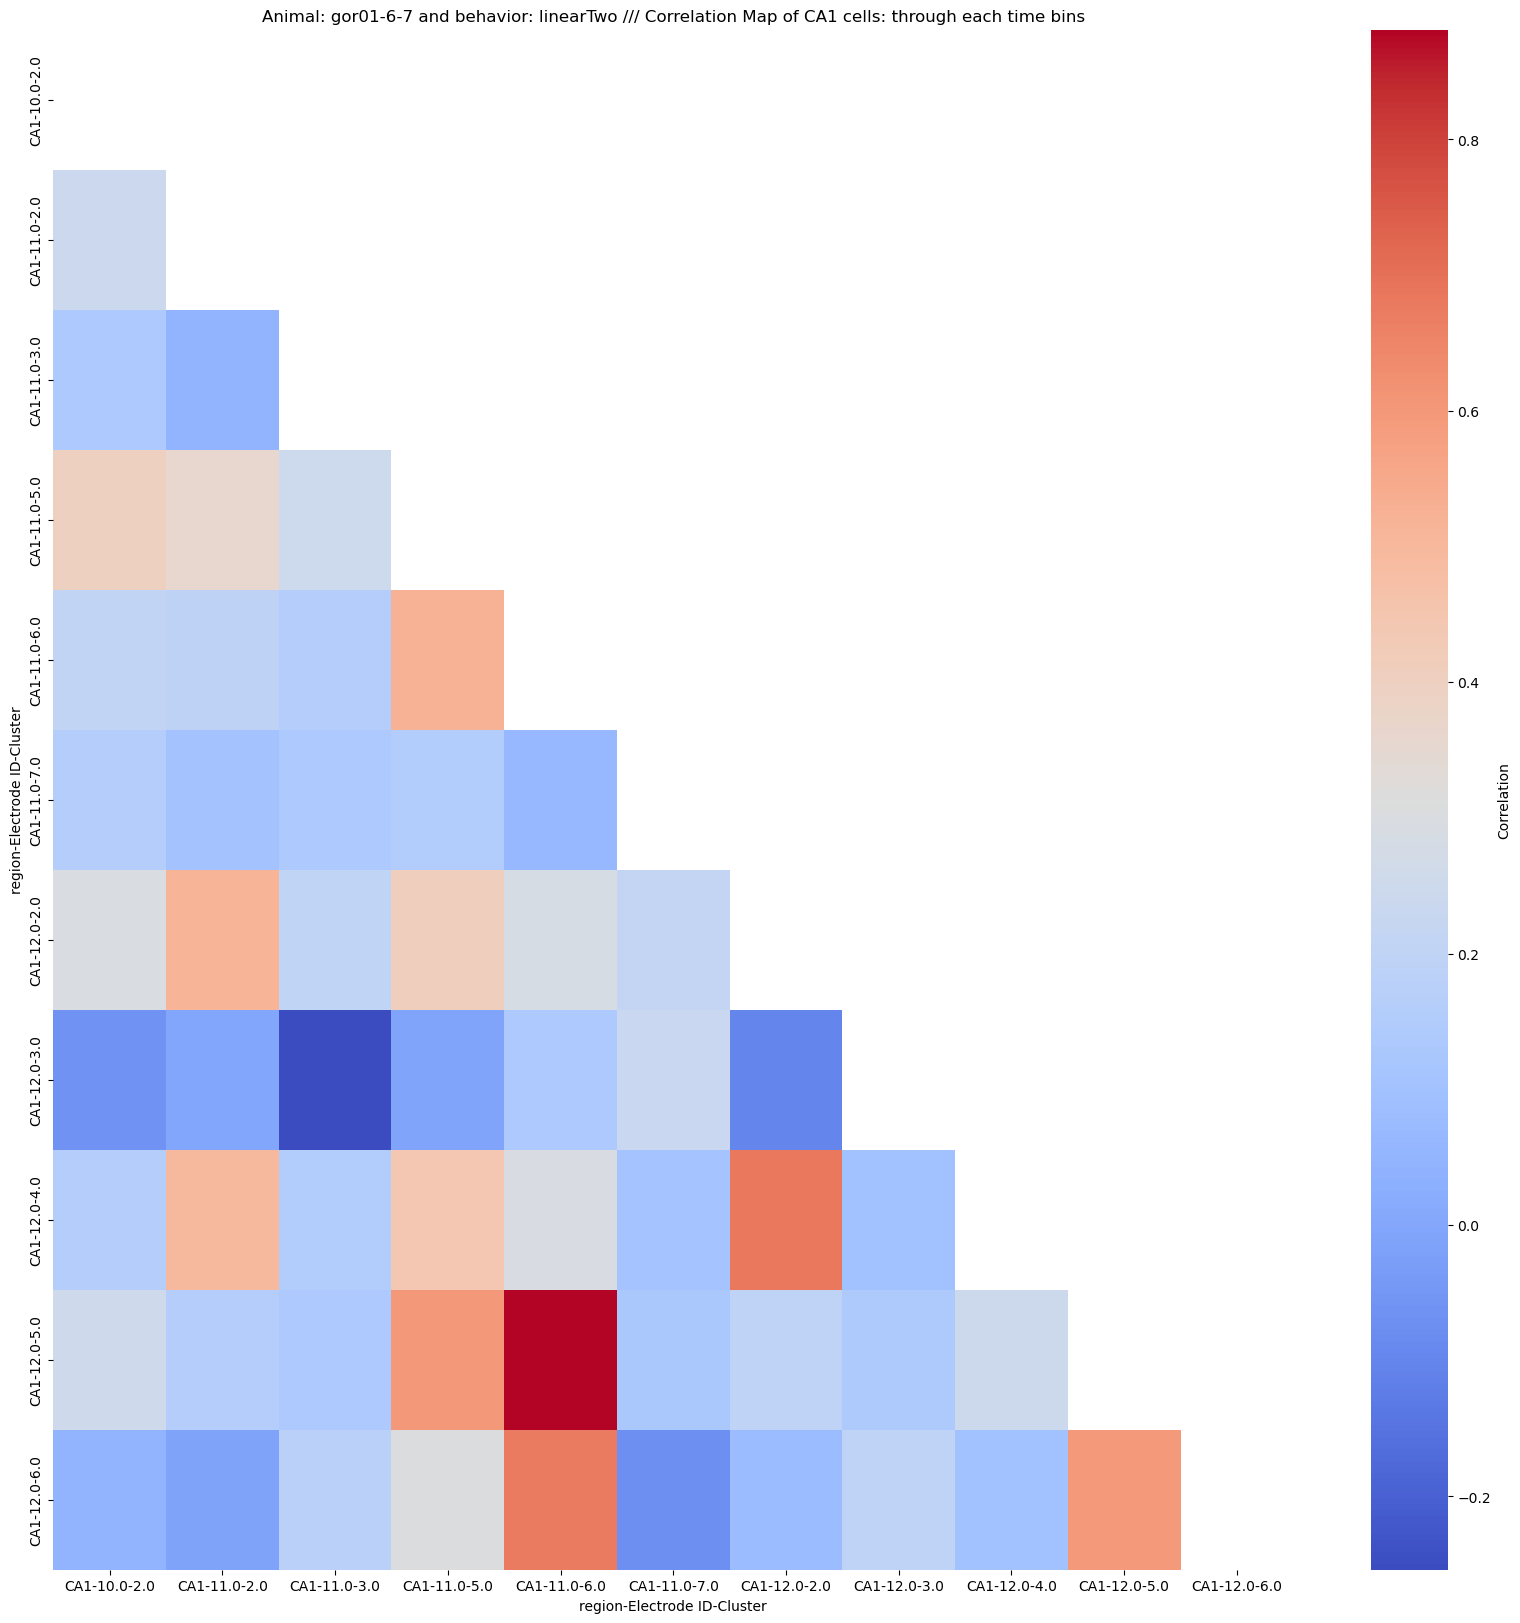

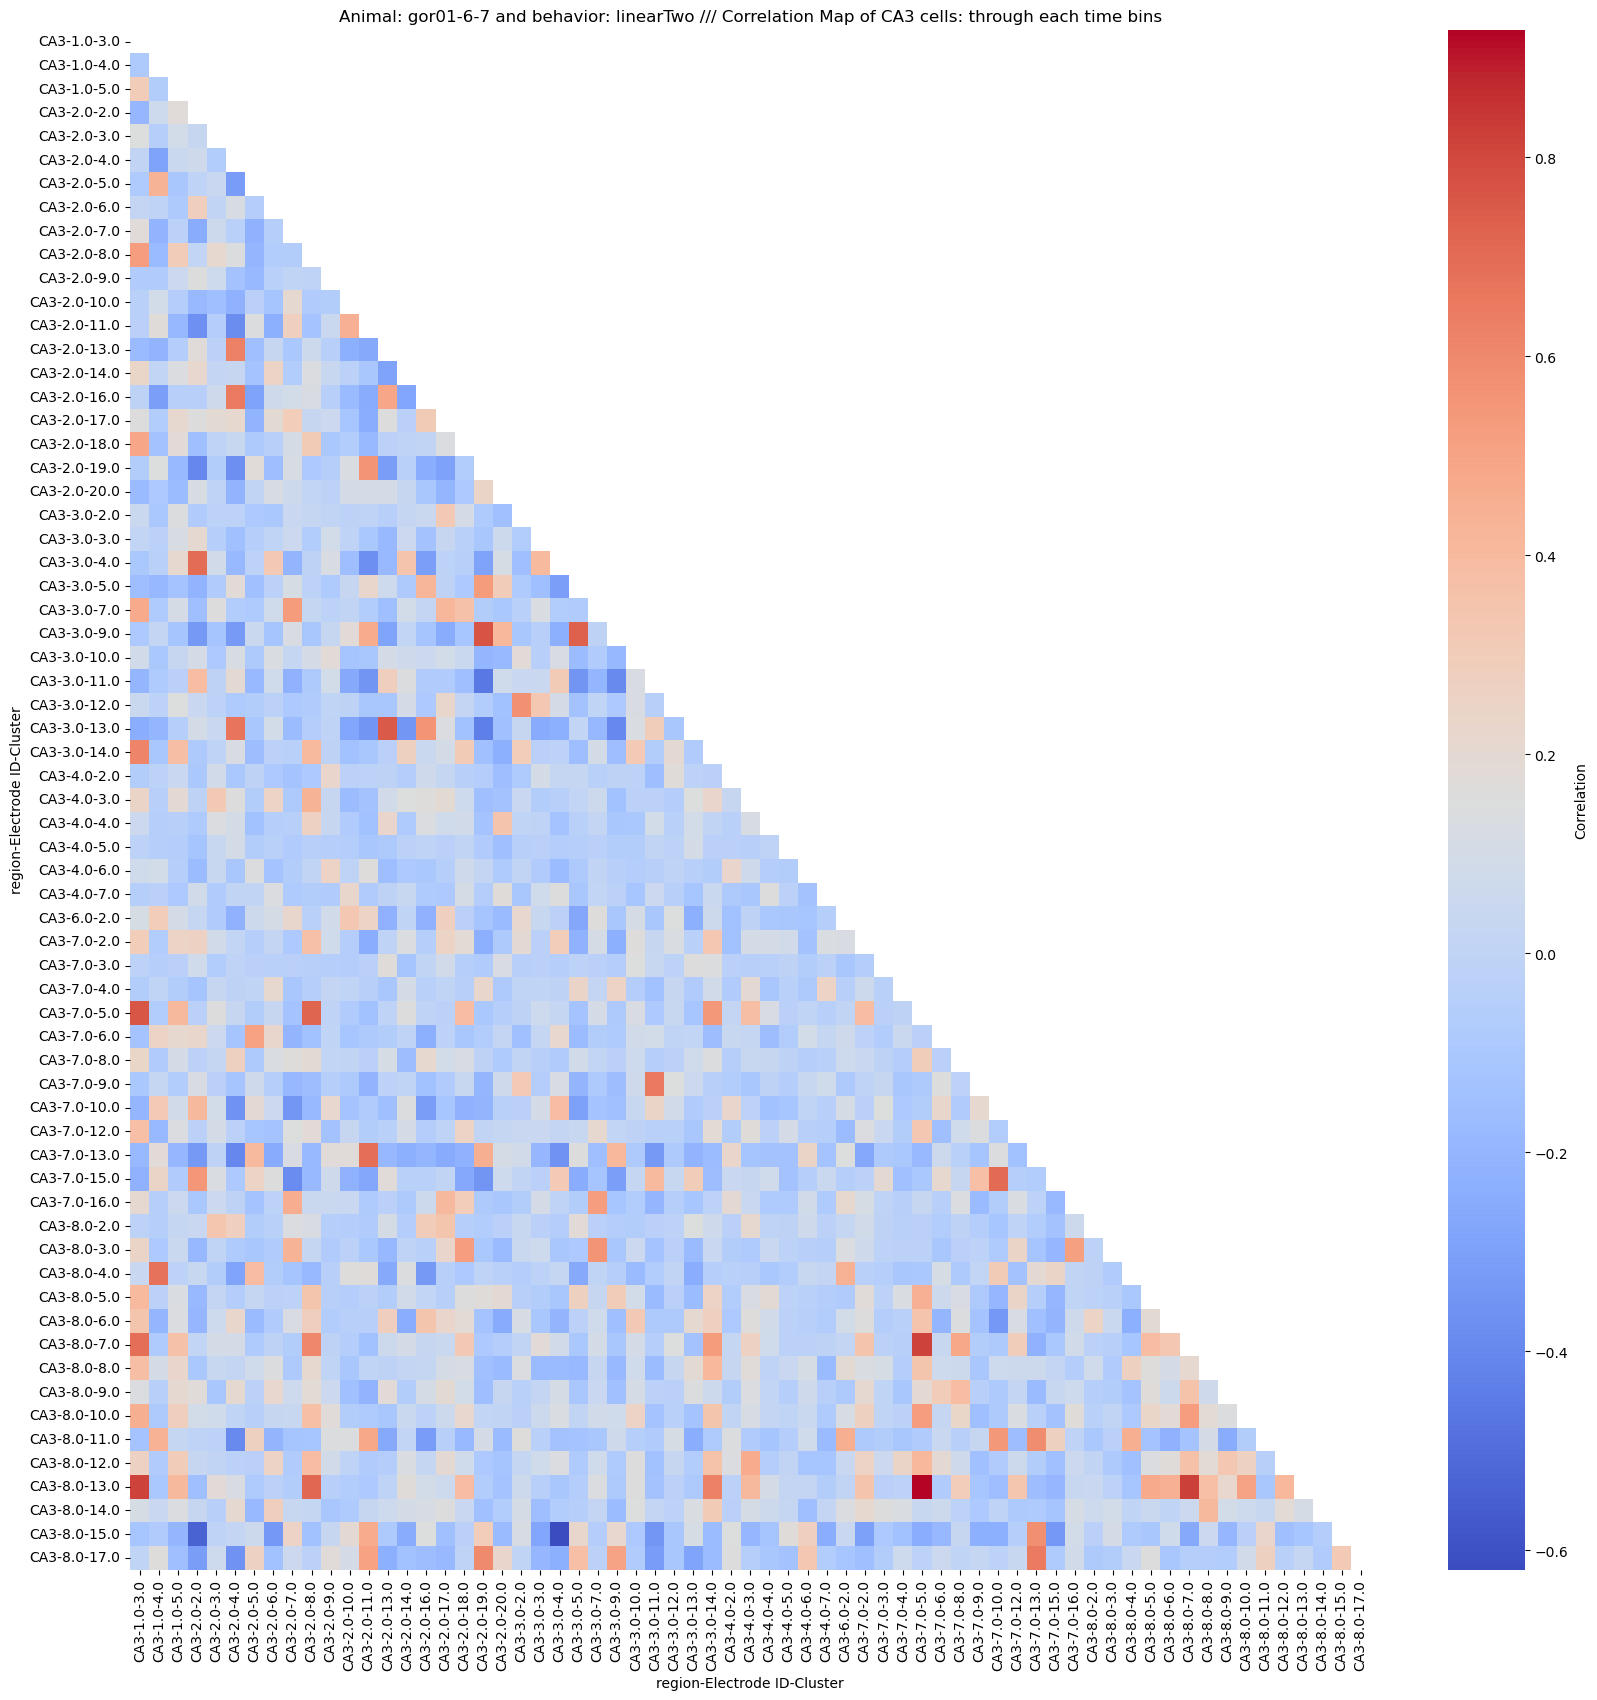

In [6]:
#find corr matrix for each region: CA1 and CA3

CA1_cells = spikes_counts_per_neurons_sorted.xs(key='CA1', level='region', axis=1, drop_level=False)
CA3_cells = spikes_counts_per_neurons_sorted.xs(key='CA3', level='region', axis=1, drop_level=False)

CA1_correlation_matrix = CA1_cells.corr()
CA3_correlation_matrix = CA3_cells.corr()


##plot them
    ## CA1
plt.figure(figsize=(20, 20))
mask = np.triu(np.ones_like(CA1_correlation_matrix, dtype=bool))
sns.heatmap(CA1_correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f", mask=mask, cbar_kws={'label': 'Correlation'})
plt.title('Animal: gor01-6-7 and behavior: linearTwo /// Correlation Map of CA1 cells: through each time bins')
plt.show()


    ## CA3

plt.figure(figsize=(20, 20))
mask = np.triu(np.ones_like(CA3_correlation_matrix, dtype=bool))
sns.heatmap(CA3_correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f", mask=mask, cbar_kws={'label': 'Correlation'})
plt.title('Animal: gor01-6-7 and behavior: linearTwo /// Correlation Map of CA3 cells: through each time bins')
plt.show()


In [7]:

### Average Corr for each Region:
    
average_correlation_CA3 = np.mean(CA3_correlation_matrix.values)
average_correlation_CA1 = np.mean(CA1_correlation_matrix.values)
print('average_correlation_CA3:',average_correlation_CA3 )
print('average_correlation_CA1:',average_correlation_CA1 )

average_correlation_CA3: 0.03488385492917847
average_correlation_CA1: 0.29320026074736


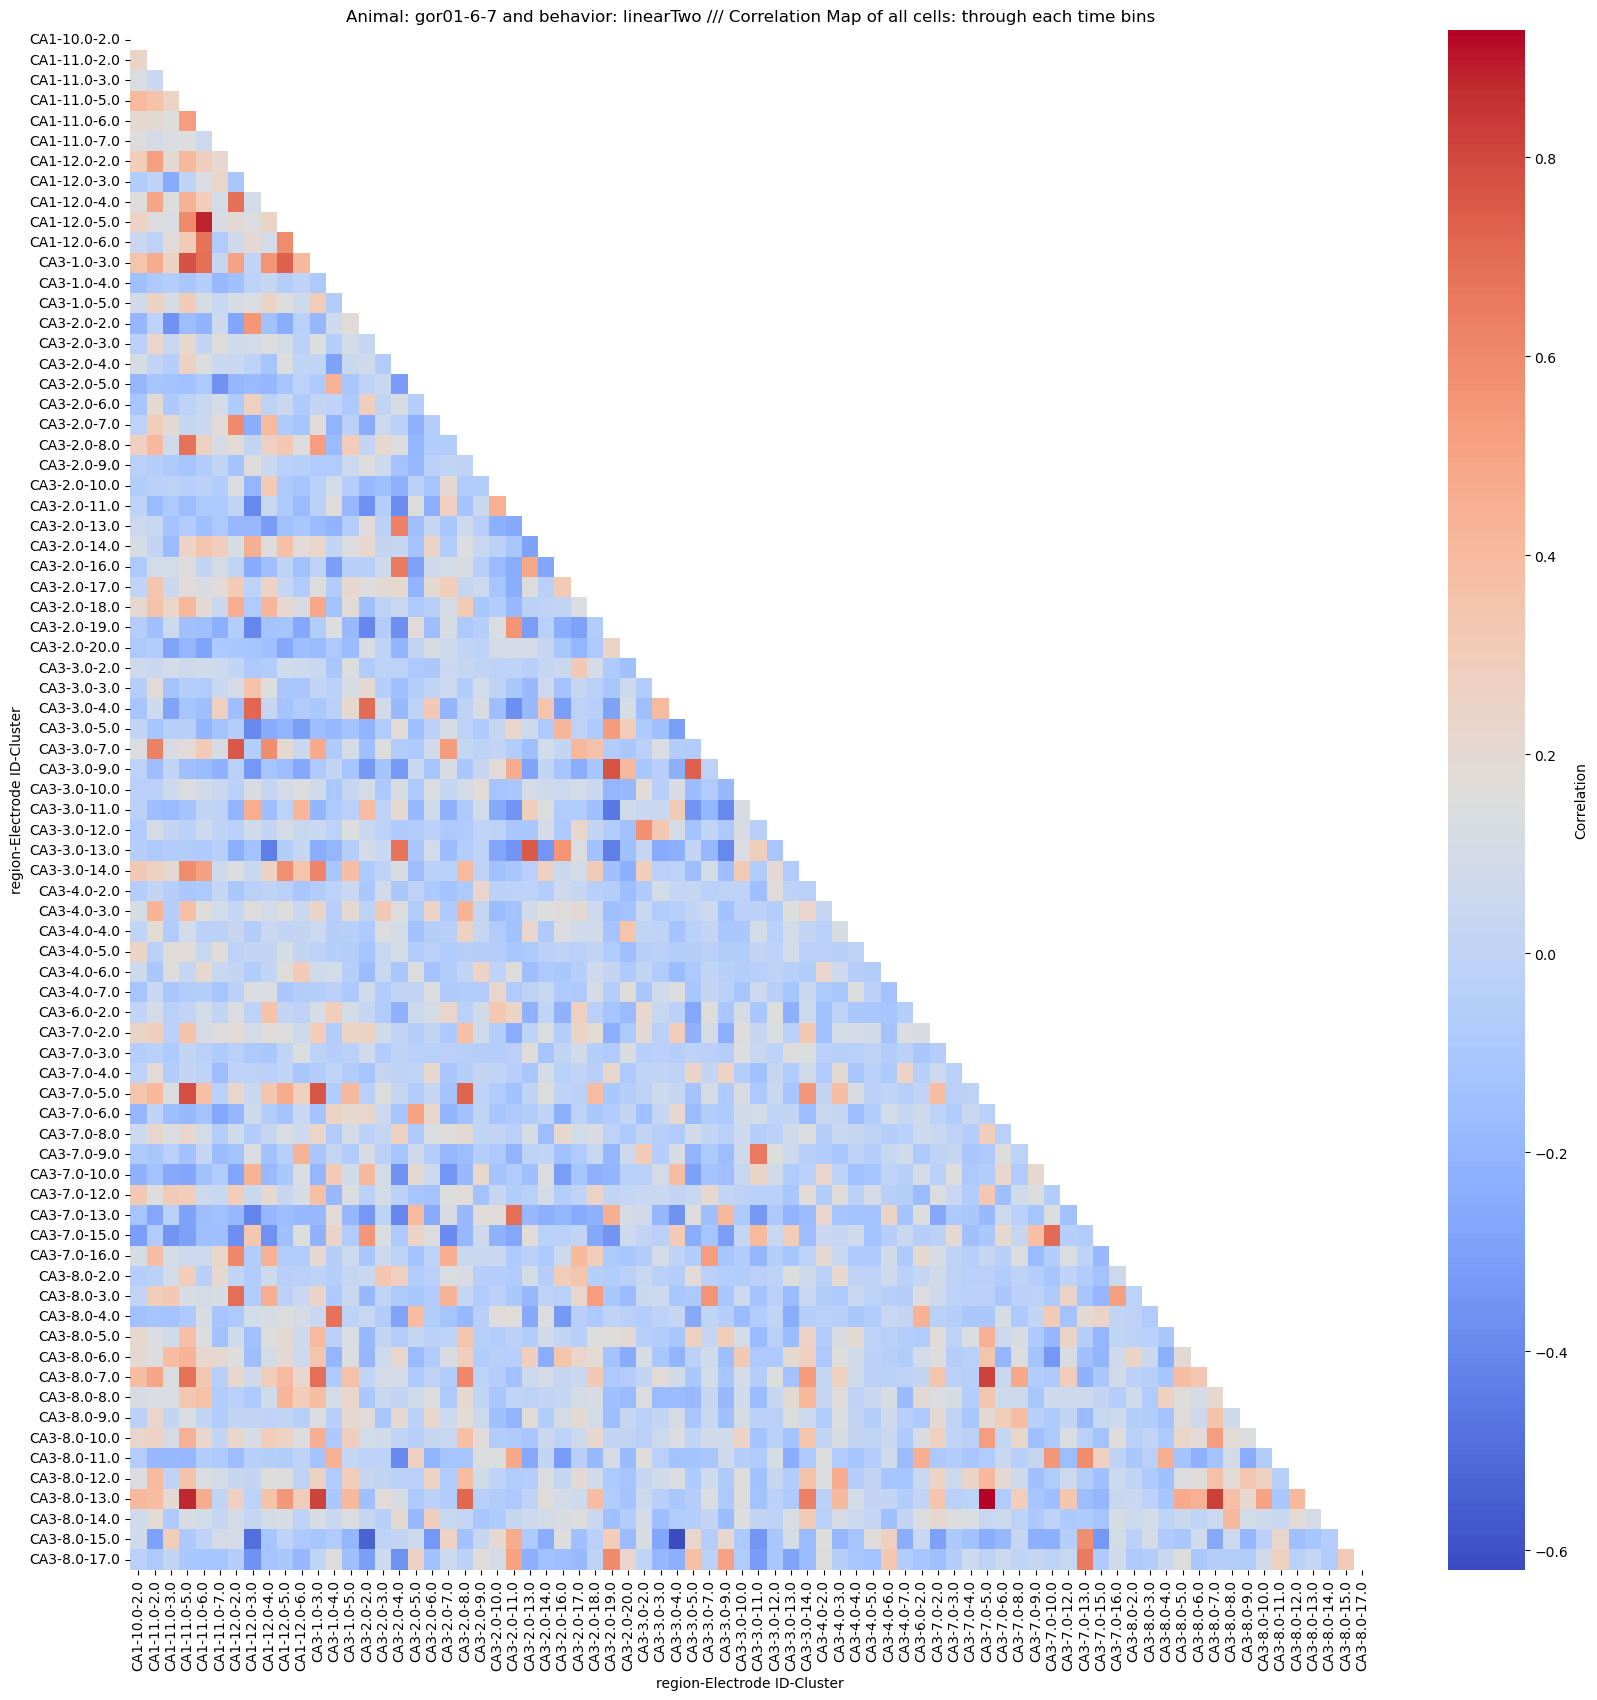

In [8]:
###correlation of all region
correlation_matrix = spikes_counts_per_neurons_sorted.corr()
plt.figure(figsize=(20, 20))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f", mask=mask, cbar_kws={'label': 'Correlation'})
plt.title('Animal: gor01-6-7 and behavior: linearTwo /// Correlation Map of all cells: through each time bins')
plt.show()


In [9]:
#get mean corr for all cells in all regions
average_correlation_all_regions = np.mean(correlation_matrix.values)

print('average correlation of all of cells of all region:',average_correlation_all_regions )

average correlation of all of cells of all region: 0.04353632714552632


# Some Plots



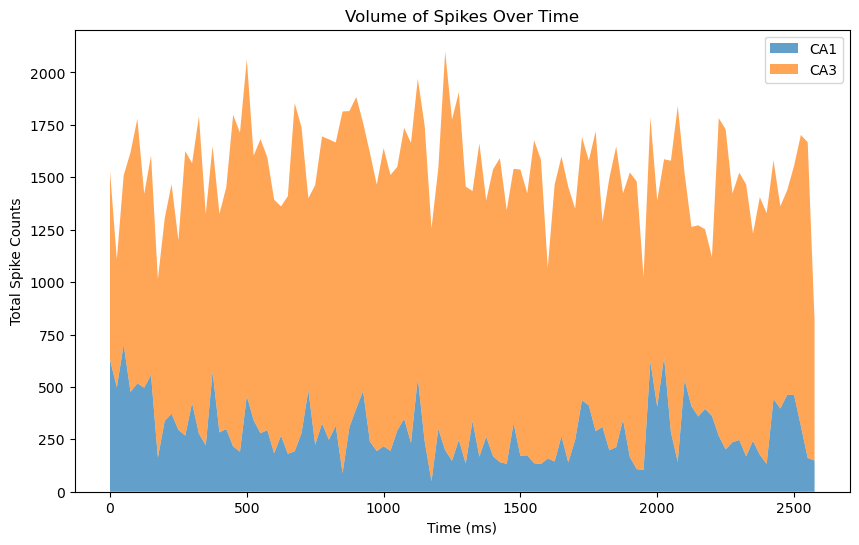

In [10]:

plt.figure(figsize=(10, 6))
plt.stackplot(CA1_cells.index, CA1_cells.sum(axis=1), CA3_cells.sum(axis=1), labels=['CA1', 'CA3'], alpha=0.7)

plt.xlabel('Time (ms)')
plt.ylabel('Total Spike Counts')
plt.title('Volume of Spikes Over Time')
plt.legend()
plt.show()


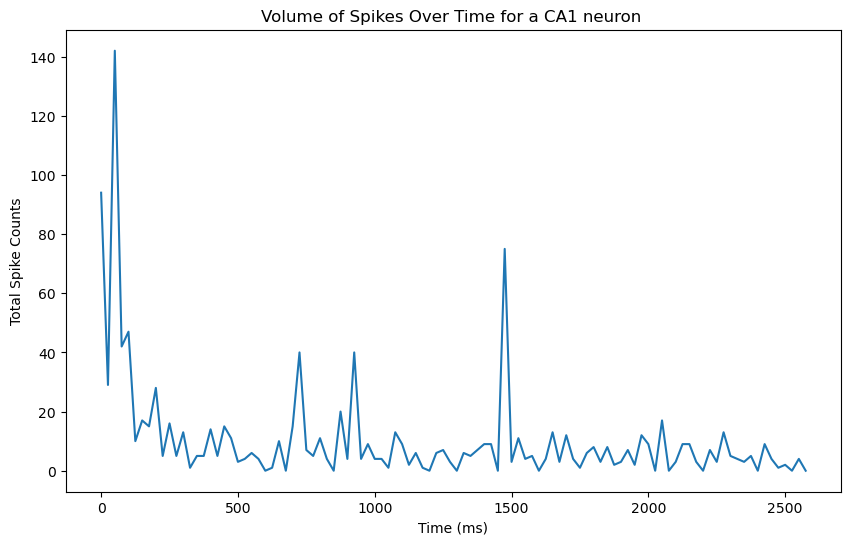

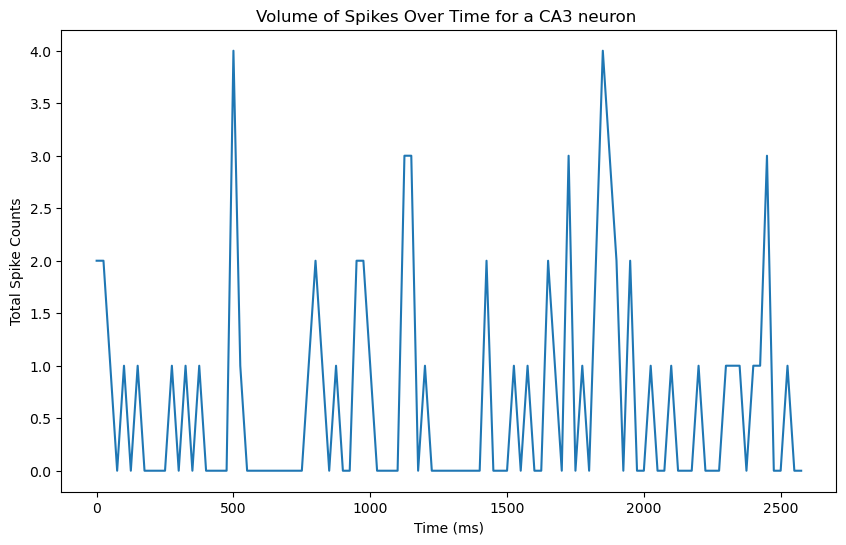

In [16]:


plt.figure(figsize=(10, 6))
plt.plot(CA1_cells.index, CA1_cells.iloc[:,4])
plt.xlabel('Time (ms)')
plt.ylabel('Total Spike Counts')
plt.title('Volume of Spikes Over Time for a CA1 neuron ')
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(CA3_cells.index, CA3_cells.iloc[:,4])
plt.xlabel('Time (ms)')
plt.ylabel('Total Spike Counts')
plt.title('Volume of Spikes Over Time for a CA3 neuron ')
plt.show()

# Assembly pattern identification

### Determine number of significant patterns and  Identify assembly pattern composition

##### for each region!

#### CA1

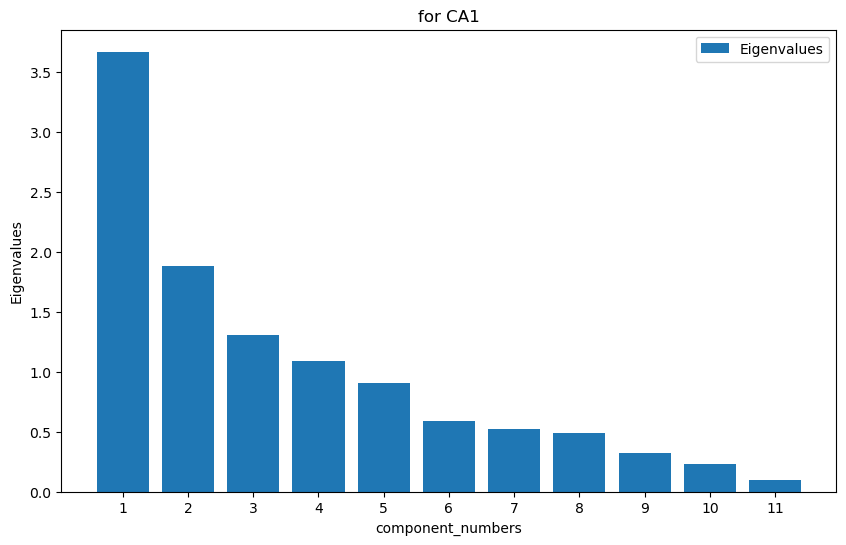

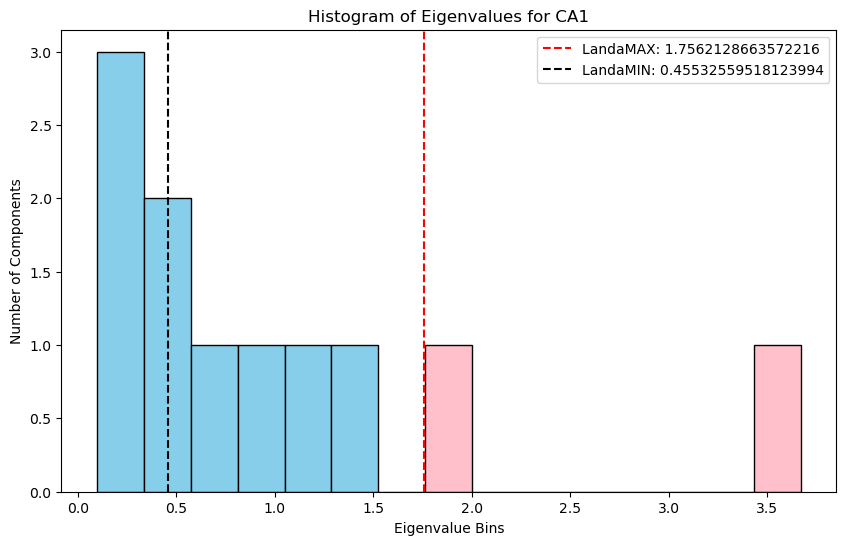

In [43]:
scaler = StandardScaler()
CA1_cells_scaled = scaler.fit_transform(CA1_cells)# normalization 
pca = PCA(n_components = len(CA1_cells.columns),random_state=0)# number of component== number of neurons 

pcomp= pca.fit_transform(CA1_cells_scaled)

components=pca.components_
eigenvalues = pca.explained_variance_


n=len(CA1_cells.columns)# number of neurons 
B=len(CA1_cells.index)# number of bins
LandaMAX=(1+(np.sqrt(n/B)))**2
LandaMIN=(1-(np.sqrt(n/B)))**2
distinct_significant_patterns=np.column_stack(np.where(eigenvalues>= LandaMAX))
#plot each component based on its eigenvalue
plt.figure(figsize=(10, 6))
component_numbers = np.arange(1, len(components) + 1)
plt.bar(component_numbers, eigenvalues, label='Eigenvalues')
plt.xlabel('component_numbers')
plt.ylabel('Eigenvalues')
plt.title('for CA1')
plt.legend()
plt.xticks(component_numbers)
plt.show()

## figure S2-A[2]

num_bins_eigens = 15
min_value = np.min(eigenvalues)
max_value = np.max(eigenvalues)
bin_edges = np.linspace(min_value, max_value, num_bins_eigens + 1)

# Create a histogram
hist, bin_edges = np.histogram(eigenvalues, bins=bin_edges)
plt.figure(figsize=(10, 6))

for i in range(num_bins_eigens):
    color = 'pink' if bin_edges[i] > LandaMAX else 'skyblue'
    plt.bar(bin_edges[i], hist[i], width=bin_edges[i + 1] - bin_edges[i], align='edge', edgecolor='black', color=color)

plt.xlabel('Eigenvalue Bins')
plt.ylabel('Number of Components')
plt.title('Histogram of Eigenvalues for CA1')
plt.axvline(LandaMAX, linestyle='--', color='red', label=f'LandaMAX: {LandaMAX}')
plt.axvline(LandaMIN, linestyle='--', color='black', label=f'LandaMIN: {LandaMIN}')

plt.legend()
plt.show()

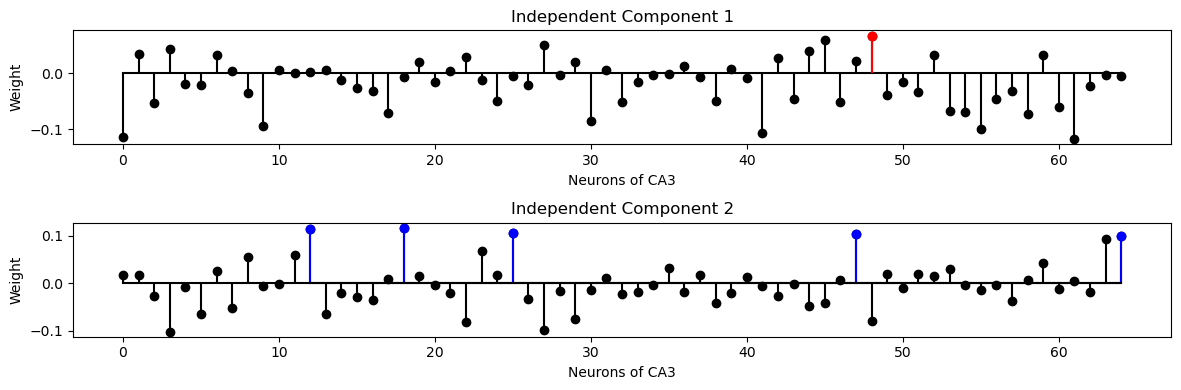

In [44]:

ica = FastICA(n_components=len(distinct_significant_patterns), random_state=0)
ica.fit(CA3_cells_scaled)
comp_weight = ica.components_

#Plotting
num_components = comp_weight.shape[0] 
plt.figure(figsize=(12, 2*num_components))

colors = plt.cm.viridis(np.linspace(0, 1, comp_weight.shape[1]))

for i in range(num_components):
    plt.subplot(num_components, 1, i+1)
    
    # Find neurons whose weight exceeds mean + 2 * std
    threshold = np.mean(comp_weight[i, :]) + 2 * np.std(comp_weight[i, :])
    highlighted_neurons = np.where(comp_weight[i, :] > threshold)[0]
    

    if i == 0:
        plt.stem(comp_weight[i, :], label=f"IC {i+1}", linefmt='k-', markerfmt='ko', basefmt='k-')

        plt.stem(highlighted_neurons, comp_weight[i, highlighted_neurons], linefmt='r-', markerfmt='ro', basefmt='k-')

        plt.title(f"Independent Component {i+1}")
        plt.xlabel("Neurons of CA3")
        plt.ylabel("Weight")

    
    else:
          
        plt.stem(comp_weight[i, :], label=f"IC {i+1}", linefmt='k-', markerfmt='ko', basefmt='k-')
        plt.stem(highlighted_neurons, comp_weight[i, highlighted_neurons], linefmt='b-', markerfmt='bo', basefmt='k-')
        plt.title(f"Independent Component {i+1}")
        plt.xlabel("Neurons of CA3")
        plt.ylabel("Weight")
    
plt.tight_layout()
plt.show()


### CA3

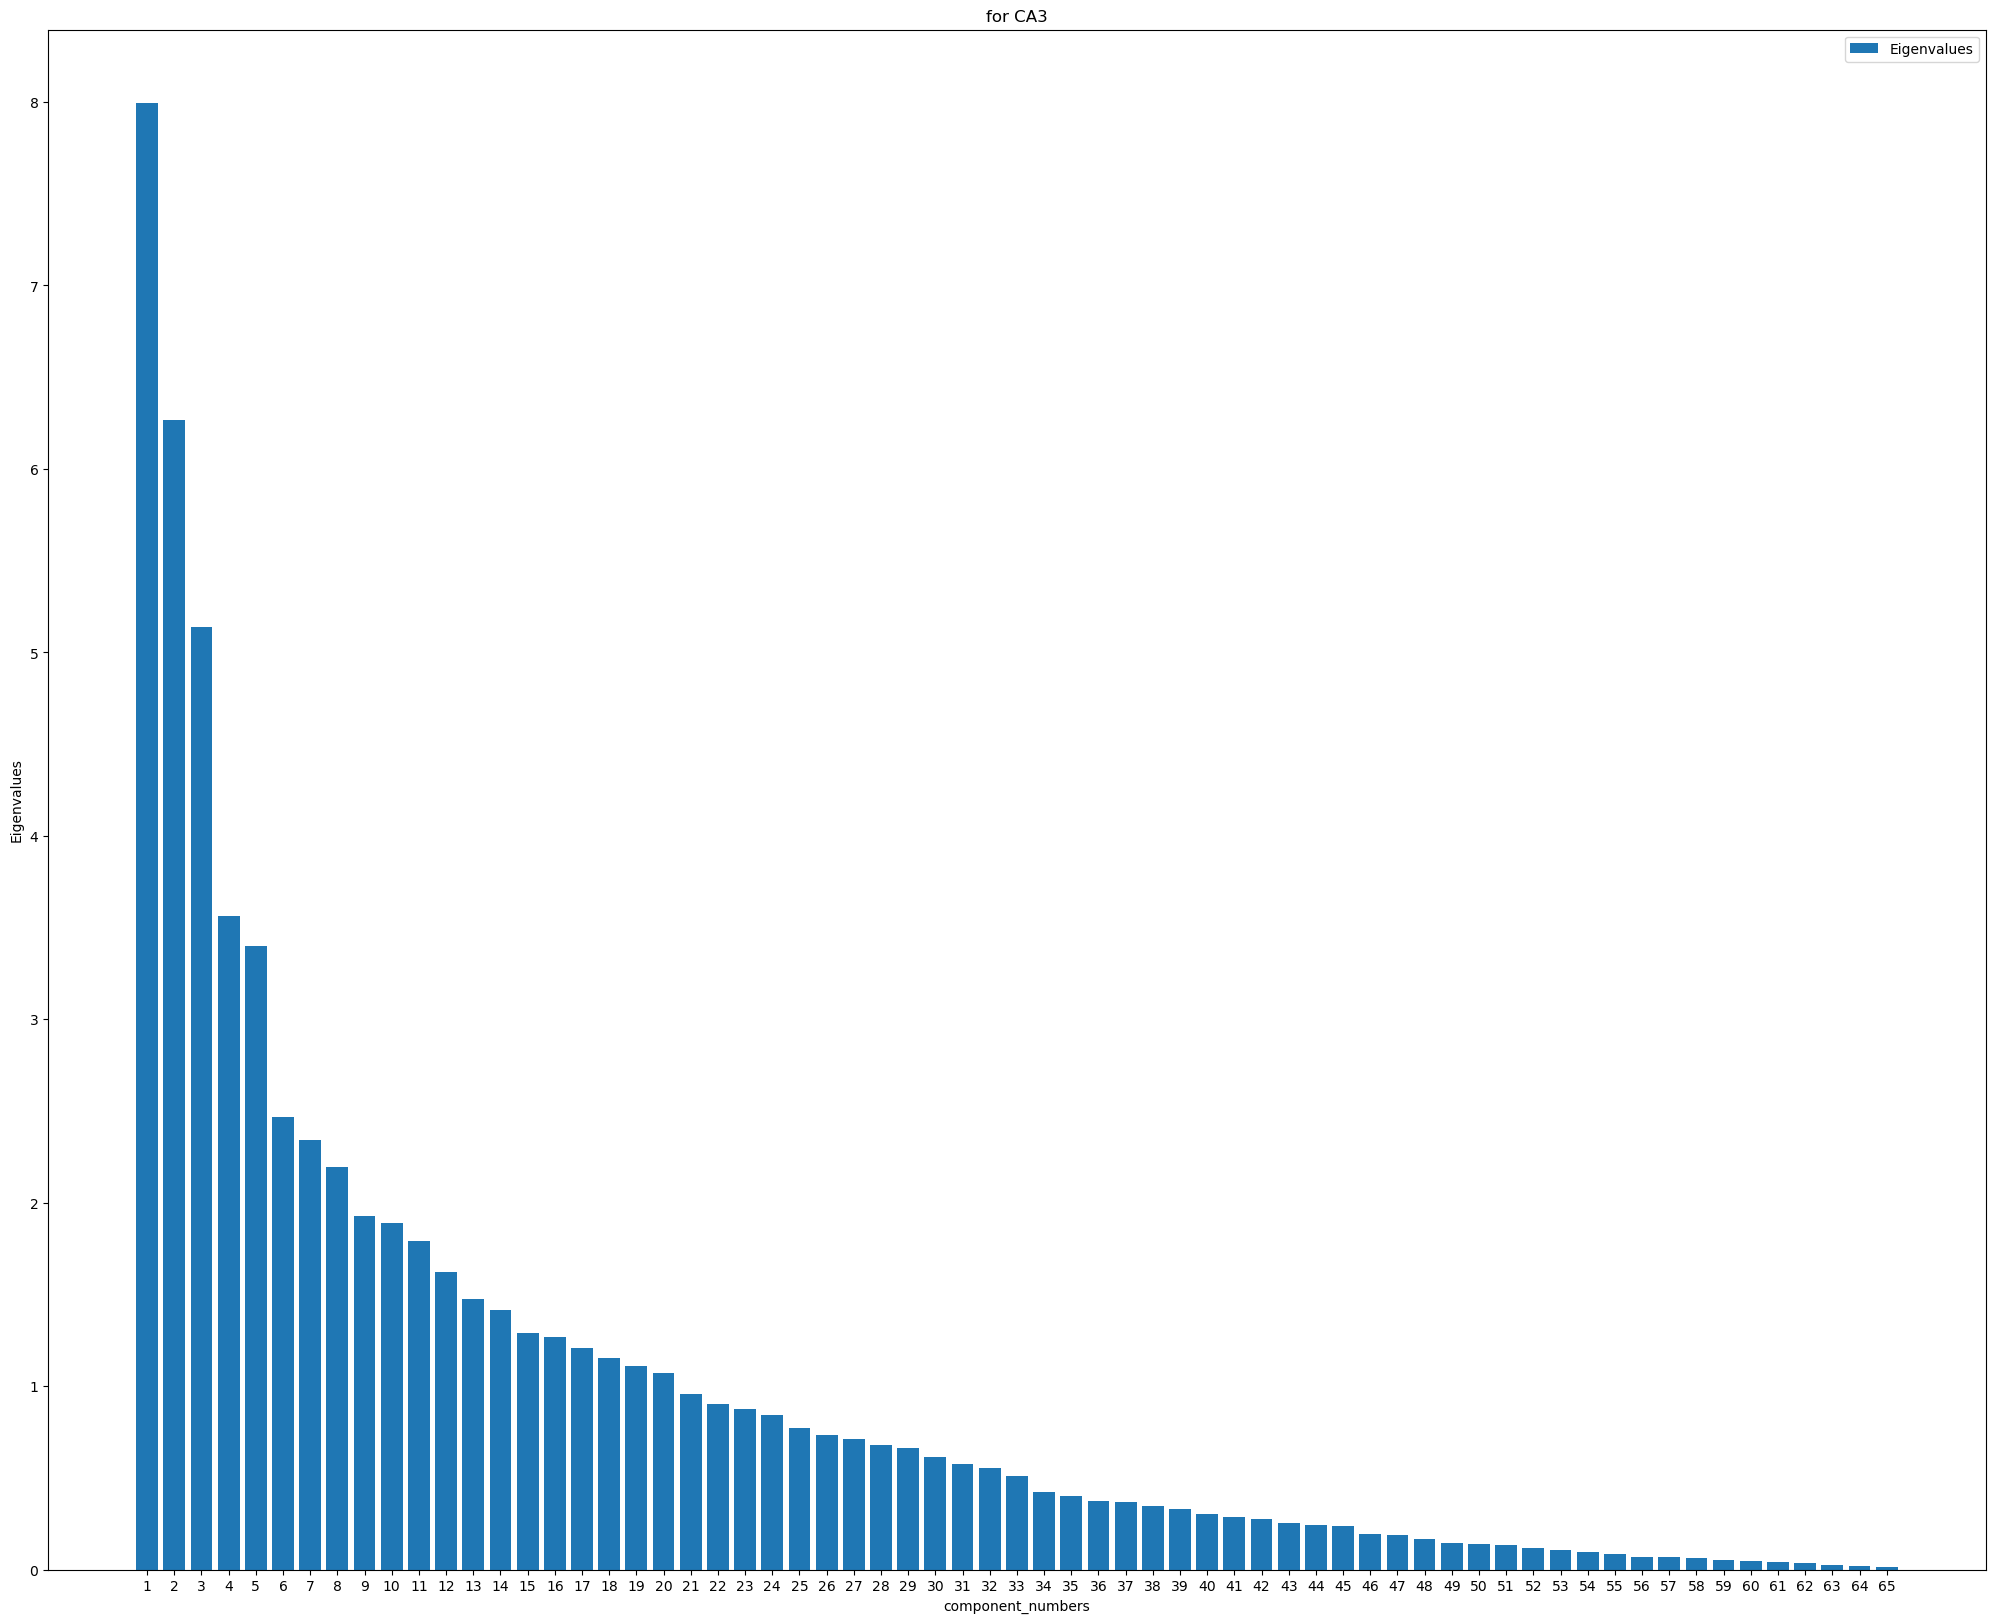

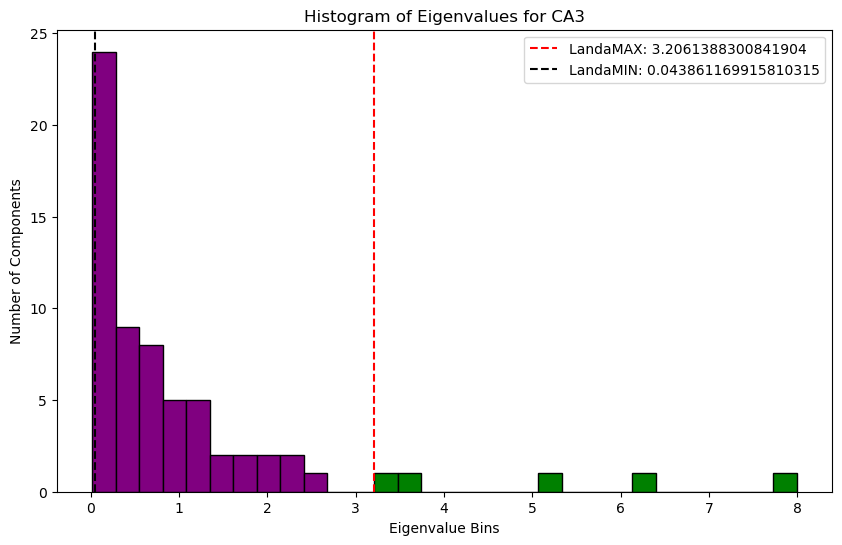

In [45]:
scaler = StandardScaler()
CA3_cells_scaled = scaler.fit_transform(CA3_cells)# normalization 
pca = PCA(n_components = len(CA3_cells.columns),random_state=0)# number of component== number of neurons 

pcomp= pca.fit_transform(CA3_cells_scaled)

components=pca.components_
eigenvalues = pca.explained_variance_


n=len(CA3_cells.columns)# number of neurons 
B=len(CA3_cells.index)# number of bins
LandaMAX=(1+(np.sqrt(n/B)))**2
LandaMIN=(1-(np.sqrt(n/B)))**2
distinct_significant_patterns=np.column_stack(np.where(eigenvalues>= LandaMAX))
#plot each component based on its eigenvalue
plt.figure(figsize=(25, 20))
component_numbers = np.arange(1, len(components) + 1)
plt.bar(component_numbers, eigenvalues, label='Eigenvalues')
plt.xlabel('component_numbers')
plt.ylabel('Eigenvalues')
plt.title('for CA3')
plt.legend()
plt.xticks(component_numbers)
plt.show()

## figure S2-A[2]

num_bins_eigens = 30
min_value = np.min(eigenvalues)
max_value = np.max(eigenvalues)
bin_edges = np.linspace(min_value, max_value, num_bins_eigens + 1)

# Create a histogram
hist, bin_edges = np.histogram(eigenvalues, bins=bin_edges)
plt.figure(figsize=(10, 6))

for i in range(num_bins_eigens):
    color = 'green' if bin_edges[i] > LandaMAX else 'purple'
    plt.bar(bin_edges[i], hist[i], width=bin_edges[i + 1] - bin_edges[i], align='edge', edgecolor='black', color=color)

plt.xlabel('Eigenvalue Bins')
plt.ylabel('Number of Components')
plt.title('Histogram of Eigenvalues for CA3')
plt.axvline(LandaMAX, linestyle='--', color='red', label=f'LandaMAX: {LandaMAX}')
plt.axvline(LandaMIN, linestyle='--', color='black', label=f'LandaMIN: {LandaMIN}')

plt.legend()
plt.show()

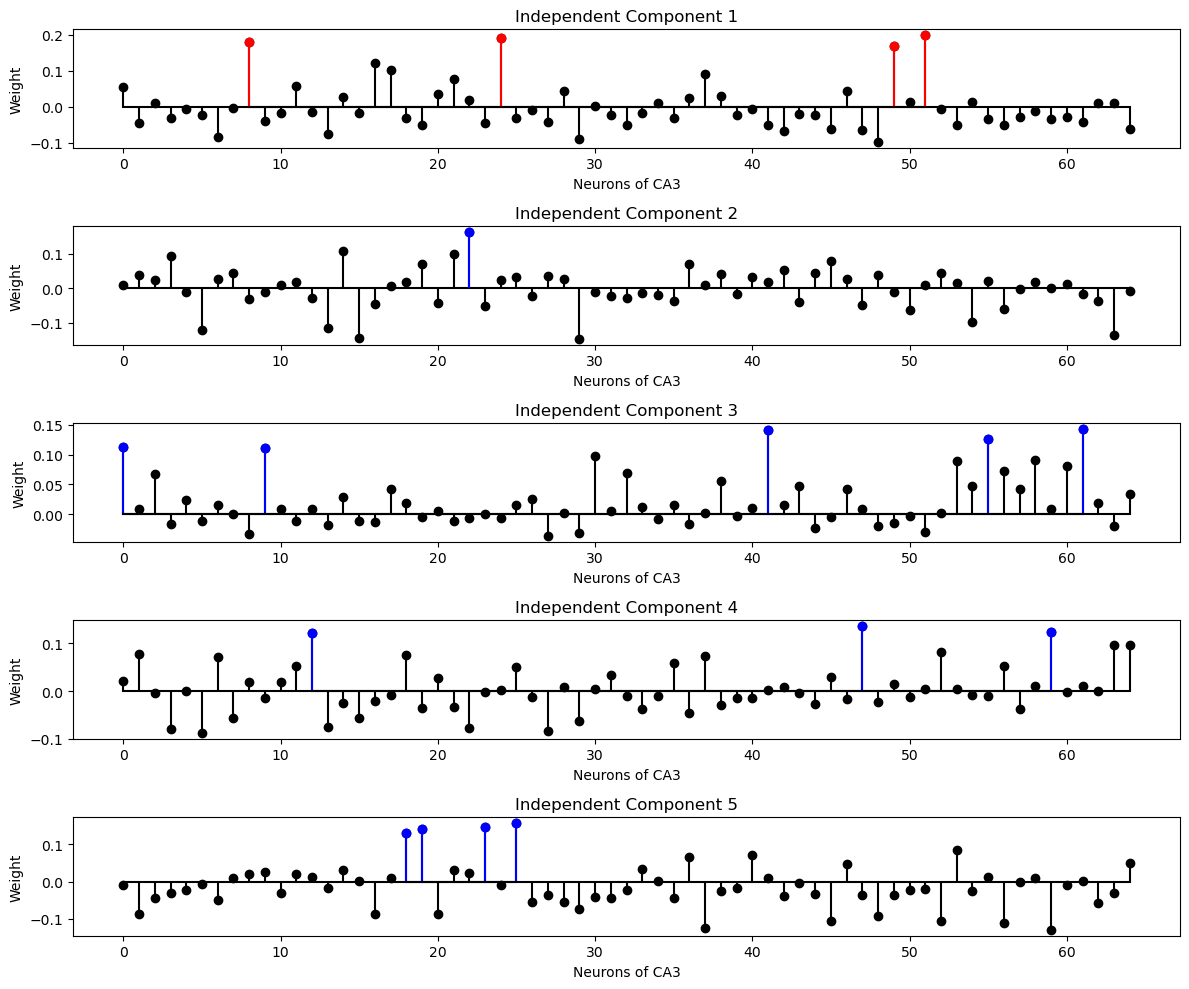

In [46]:

ica = FastICA(n_components=len(distinct_significant_patterns),max_iter=1000, random_state=0)
ica.fit(CA3_cells_scaled)
comp_weight = ica.components_

#Plotting
num_components = comp_weight.shape[0] 
plt.figure(figsize=(12, 2*num_components))

colors = plt.cm.viridis(np.linspace(0, 1, comp_weight.shape[1]))

for i in range(num_components):
    plt.subplot(num_components, 1, i+1)
    
    # Find neurons whose weight exceeds mean + 2 * std
    threshold = np.mean(comp_weight[i, :]) + 2 * np.std(comp_weight[i, :])
    highlighted_neurons = np.where(comp_weight[i, :] > threshold)[0]
    

    if i == 0:
        plt.stem(comp_weight[i, :], label=f"IC {i+1}", linefmt='k-', markerfmt='ko', basefmt='k-')

        plt.stem(highlighted_neurons, comp_weight[i, highlighted_neurons], linefmt='r-', markerfmt='ro', basefmt='k-')

        plt.title(f"Independent Component {i+1}")
        plt.xlabel("Neurons of CA3")
        plt.ylabel("Weight")

    
    else:
          
        plt.stem(comp_weight[i, :], label=f"IC {i+1}", linefmt='k-', markerfmt='ko', basefmt='k-')
        plt.stem(highlighted_neurons, comp_weight[i, highlighted_neurons], linefmt='b-', markerfmt='bo', basefmt='k-')
        plt.title(f"Independent Component {i+1}")
        plt.xlabel("Neurons of CA3")
        plt.ylabel("Weight")
    
plt.tight_layout()
plt.show()


### For CA1 AND CA3

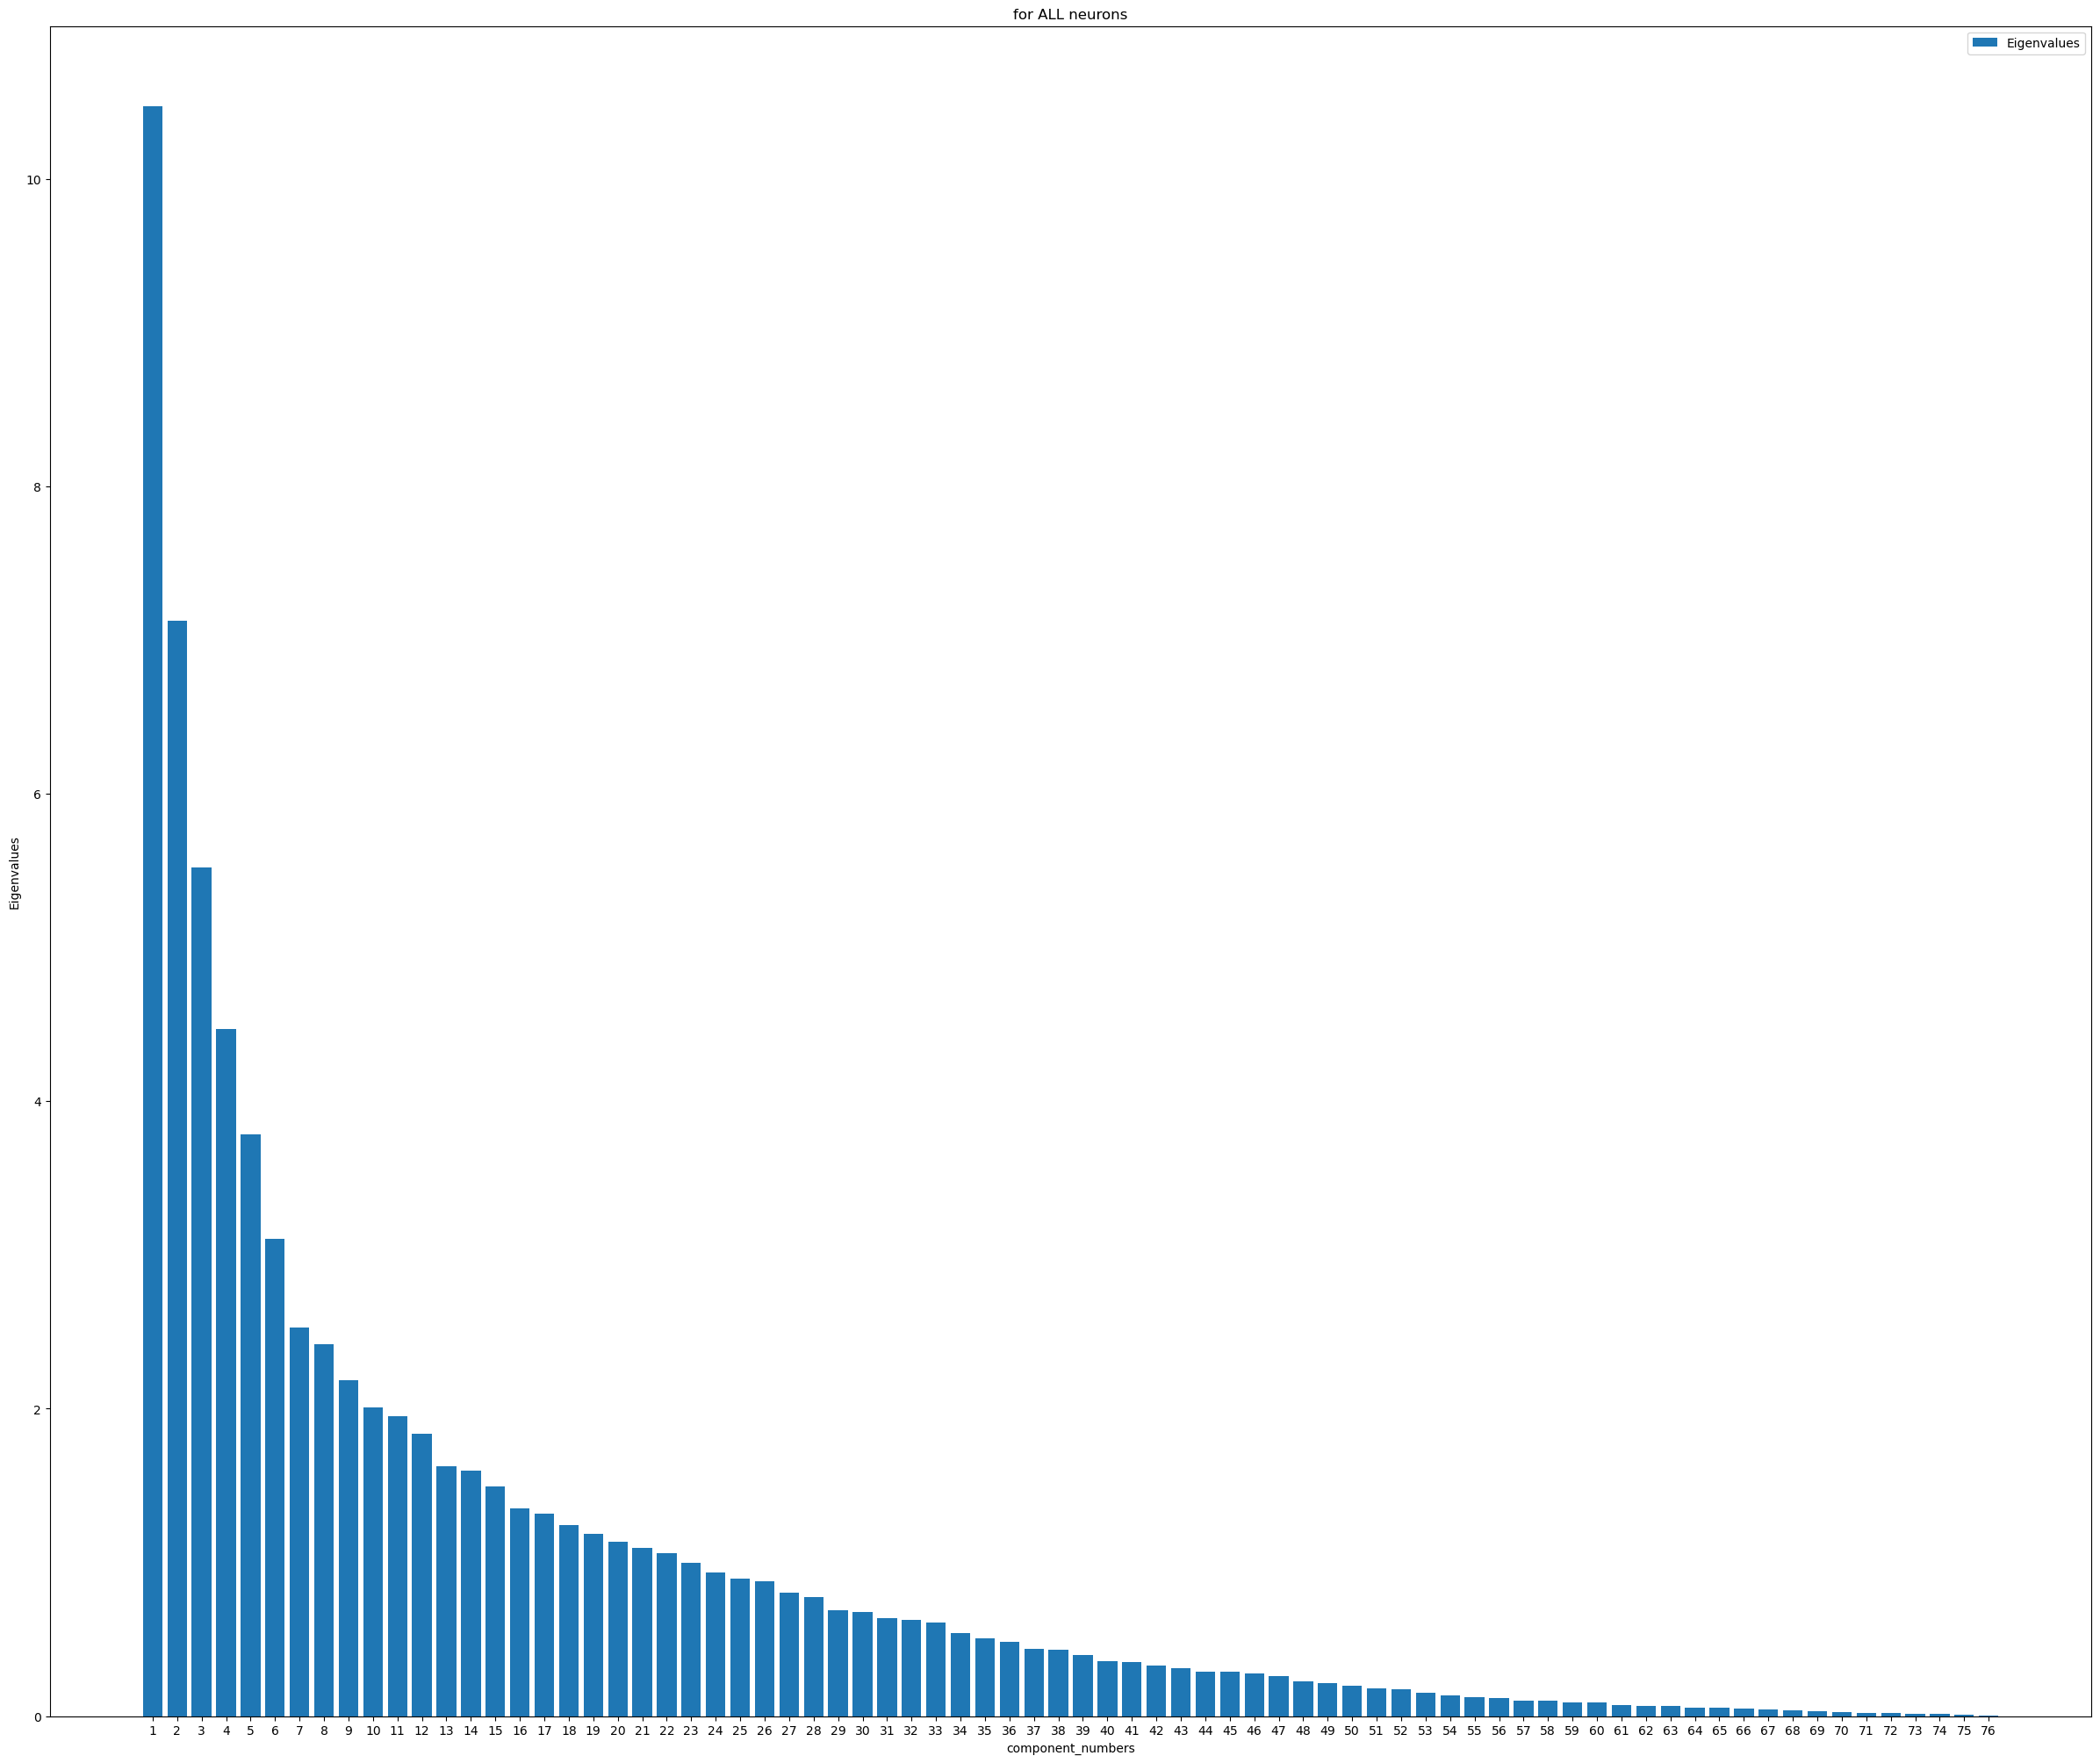

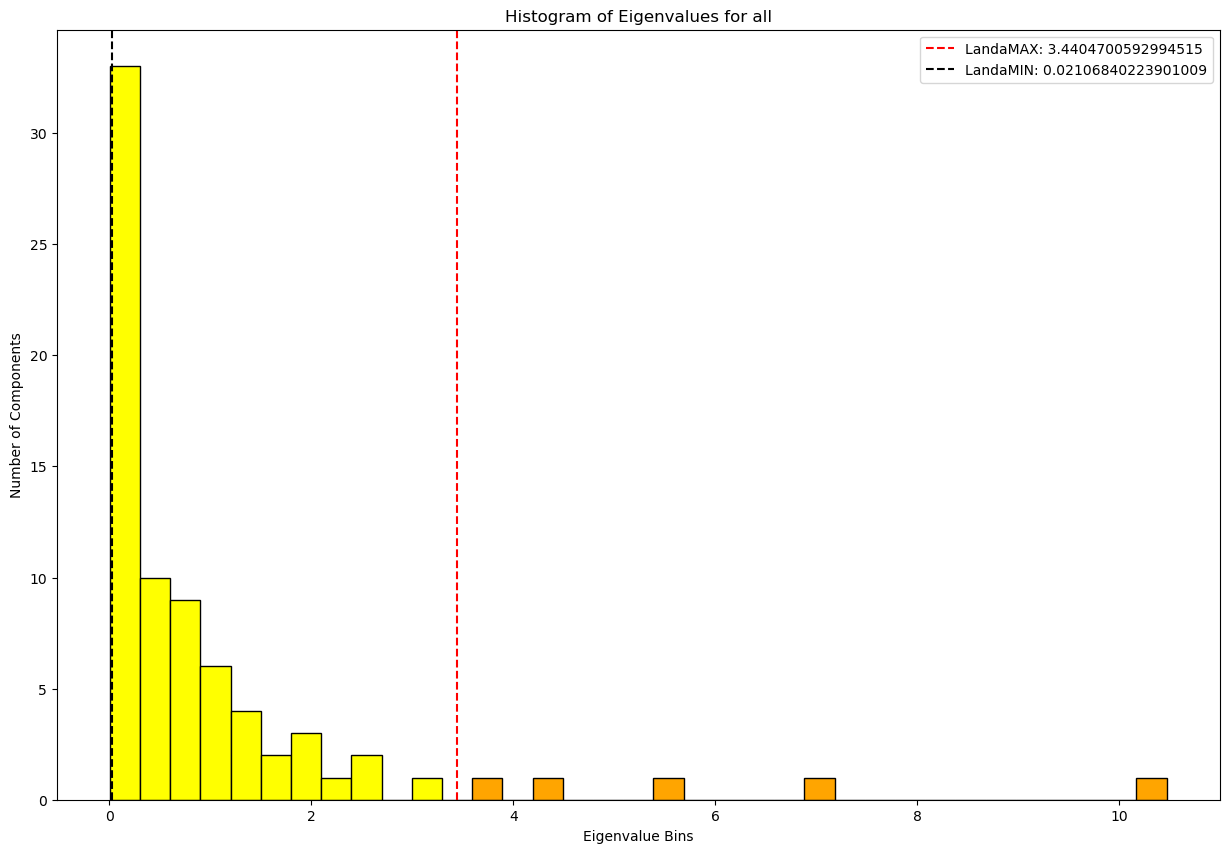

In [47]:
scaler = StandardScaler()
ALL_cells_scaled = scaler.fit_transform(spikes_counts_per_neurons_sorted)# normalization 
pca = PCA(n_components = len(spikes_counts_per_neurons_sorted.columns),random_state=0)# number of component== number of neurons 

pcomp= pca.fit_transform(ALL_cells_scaled)

components=pca.components_
eigenvalues = pca.explained_variance_


n=len(spikes_counts_per_neurons_sorted.columns)# number of neurons 
B=len(spikes_counts_per_neurons_sorted.index)# number of bins
LandaMAX=(1+(np.sqrt(n/B)))**2
LandaMIN=(1-(np.sqrt(n/B)))**2
distinct_significant_patterns=np.column_stack(np.where(eigenvalues>= LandaMAX))
#plot each component based on its eigenvalue
plt.figure(figsize=(30, 25))
component_numbers = np.arange(1, len(components) + 1)
plt.bar(component_numbers, eigenvalues, label='Eigenvalues')
plt.xlabel('component_numbers')
plt.ylabel('Eigenvalues')
plt.title('for ALL neurons')
plt.legend()
plt.xticks(component_numbers)
plt.show()

## figure S2-A[2]

num_bins_eigens = 35
min_value = np.min(eigenvalues)
max_value = np.max(eigenvalues)
bin_edges = np.linspace(min_value, max_value, num_bins_eigens + 1)

# Create a histogram
hist, bin_edges = np.histogram(eigenvalues, bins=bin_edges)
plt.figure(figsize=(15,10))

for i in range(num_bins_eigens):
    color = 'orange' if bin_edges[i] > LandaMAX else 'yellow'
    plt.bar(bin_edges[i], hist[i], width=bin_edges[i + 1] - bin_edges[i], align='edge', edgecolor='black', color=color)

plt.xlabel('Eigenvalue Bins')
plt.ylabel('Number of Components')
plt.title('Histogram of Eigenvalues for all')
plt.axvline(LandaMAX, linestyle='--', color='red', label=f'LandaMAX: {LandaMAX}')
plt.axvline(LandaMIN, linestyle='--', color='black', label=f'LandaMIN: {LandaMIN}')

plt.legend()
plt.show()